<a href="https://colab.research.google.com/github/KqkaricK/Tech/blob/main/lr3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ваш код
import os

import pandas as pd
import numpy as np

from scipy import stats

# from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

RAND = 10



```
# Выбран кодовый формат
```

# Лабораторная работа 3

Этот набор данных представляет собой запись о 7 распространенных различных видах рыб, продаваемых на рыбном рынке. С помощью этого набора данных можно обучить модель, которая будет предсказывать **вес рыбы**.

- Weight - weight of fish in Gram g
- Length1 - vertical length in cm
- Length2 - diagonal length in cm
- Length3 - cross length in cm
- Height - height in cm
- Width - diagonal width in cm

## EDA

1) Импортируйте файл Fish.csv, записав в переменную **df**

In [ ]:
# ваш код
df = pd.read_csv('Fish.csv')

2) Вывести первые пять строк

In [ ]:
# ваш код
df[:5]

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


3) Выведите размер датасета

In [ ]:
# ваш код
df.shape

(159, 7)

4) Вывести общую информацию о датафрейме при помощи метода info()

In [ ]:
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


5) Вывести основные описательные статистики для числовых и категориальных признаков

In [ ]:
# ваш код
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


6) Постройте тепловую карту для оценки **корреляции признаков**, что можно сказать на основании графика?

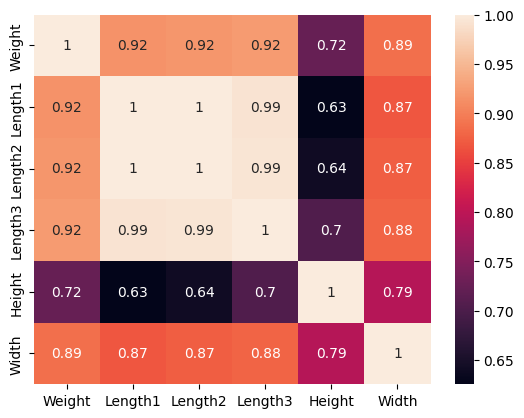

In [ ]:
# ваш код
sns.heatmap(df.corr(numeric_only=True), annot=True);

Weight имеет высокую положительную корреляцию с Length1, Length2, Length3 и Height. Это означает, что рыбы с большей длиной и высотой, как правило, тяжелее.

7) Удалите скоррелированные числовые признаки, где корреляция больше 0.9, при помощи кода ниже, где:
- df - исходный датасет
- to_drop - колонки, которые необходимо удалить

**Результат запишите в переменную df_clean**, переменную df в данном случае оставьте без изменений

In [ ]:
cor_matrix = df.drop(['Weight','Species'], axis=1).corr().abs()
upper_tri = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [
    column for column in upper_tri.columns if any(upper_tri[column] > 0.9)
]
df_clean = df.drop(columns=to_drop)
df_clean.head()

,Species,Weight,Length1,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340


8) Проанализируйте **целевую переменную Weight в df_clean**, что вы можете сказать о распределении? Нормально ли оно? проверьте при помощи стат метода

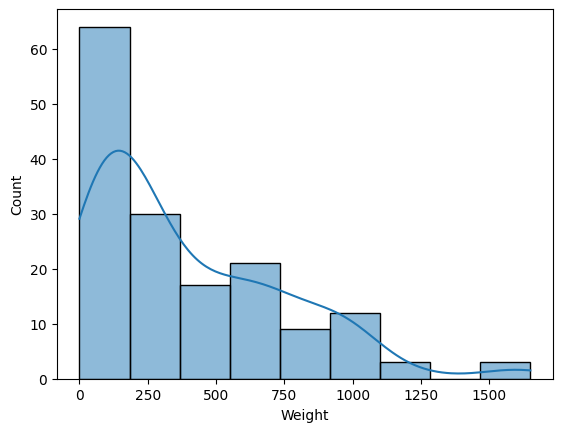

ShapiroResult(statistic=0.8834666866461098, pvalue=7.605950002031309e-10)
Распределение не нормальное


In [ ]:
# ваш код
sns.histplot(df_clean['Weight'], kde=True)
plt.show()
test_shapiro = stats.shapiro(df_clean['Weight'])
print(test_shapiro)
if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')


9) Если распределение не нормальное, то **прологарифмируйте**  таргет Weight с **добавлением внутри единицы**, **записав значения в новую колонку Weight_log** в переменнной df_clean

Проверьте, стало ли распределение нормальным при помощи стат метода.

> Если распределение не стало полностью нормальным, то ничего страшного. Для таких целей обычно используют функцию потерь устойчивую к выбросам, но мы возьмем прологарифмированную целевую переменную и представим, что распрееление все-так стало нормальным.

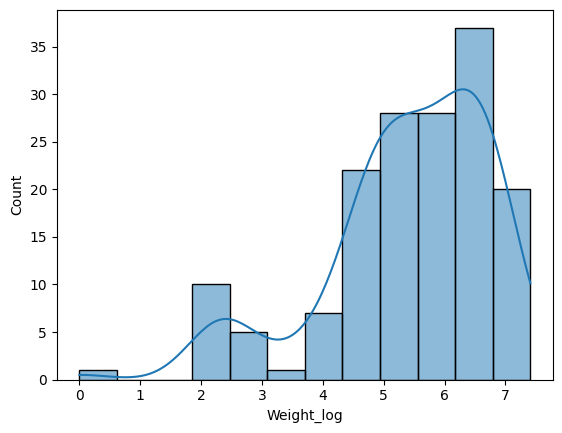

ShapiroResult(statistic=0.904837423884678, pvalue=1.1928050032225794e-08)
Распределение не нормальное


In [ ]:
# ваш код
df_clean['Weight_log'] = np.log(df_clean['Weight']+1)
sns.histplot(df_clean['Weight_log'], kde=True)
plt.show()
test_shapiro_log = stats.shapiro(df_clean['Weight_log'])
print(test_shapiro_log)
if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

10) Создайте новую переменную **df_label**, присвойте ей трансформированный датасет df_clean при помощи One-hot кодирования (лучше использовать pandas.get_dummies() для бинаризации)

Примените drop_first = True

In [ ]:
# ваш код
df_label = pd.get_dummies(df_clean, drop_first=True)
df_label.head()

,Weight,Length1,Height,Width,Weight_log,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,11.5200,4.0200,5.493061,False,False,False,False,False,False
1,290.0,24.0,12.4800,4.3056,5.673323,False,False,False,False,False,False
2,340.0,23.9,12.3778,4.6961,5.831882,False,False,False,False,False,False
3,363.0,26.3,12.7300,4.4555,5.897154,False,False,False,False,False,False
4,430.0,26.5,12.4440,5.1340,6.066108,False,False,False,False,False,False


## Modeling

11) Разбиение данных на train/test

- Разбейте данные на тренировочные и тестовые test_size=0.25
- Установите константу RAND = 10 в самом начале и используйте далее как random_state
- **Не забывайте про стандартизацию**
- Не забывайте, что нужно для записи в переменную X удалить целевые переменные 'Weight', 'Weight_log'
- Если вы логарифмировали y_test, то незабудьте создать к примеру новую переменную y_test_exp (произвести **ПОТЕНЦИОНИРОВАНИЕ**), чтобы правильно анализировать значения метрик

> Как сделать потенционирование? При условии, что при логарифмировании добавляли единицу
```python
y_test_exp = np.exp(y_test) - 1
```

In [ ]:
# ваш код
X = df_label.drop(columns=['Weight', 'Weight_log'])
y = df_label['Weight_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_test_exp = np.exp(y_test) - 1

12) Необходимо реализовать алгоритм Linear Regression при помощи метода оптимизации **стохастический градиентный спуск**

Необходимо взять пример из лекции, где реализована линейная регрессия без использования sklearn, и немного поменять алгоритм.

- Не забываем, что нам нет необходимости суммировать результат по всей выборке! Смотреть формулу из презентации
- А также будьте аккуратны при вычитании антиградиента (не будет нормирования на всю длину X)!

In [ ]:
# ваш код
class SGDLinearRegression:
    def __init__(self,
                 learning_rate: float = 0.001,
                 eps: float = 0.001,
                 iters: int = 100):
        self.learning_rate = learning_rate
        self.eps = eps
        self.iters = iters
    def mean_squared_error_cost(self, y_true: np.ndarray, y_pred: np.ndarray):
        errors = (y_true - y_pred)
        return (errors**2).sum() / len(errors)
    def net_input(self, X: np.ndarray):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def predict(self, X: np.ndarray):
        return self.net_input(X)
    def fit(self, X: np.ndarray, y: np.ndarray):
        np.random.seed(RAND)
        self.w_ = np.random.rand(1 + X.shape[1])
        self.cost_ = []
        for i in tqdm_notebook(range(self.iters)):
            w_pred = self.w_.copy()
            output = self.net_input(X)
            errors = y - output
            self.w_[1:] -= self.learning_rate * (-2 / X.shape[0]) * X.T.dot(errors)
            self.w_[0] -= self.learning_rate * (-2 / X.shape[0]) * errors.sum()
            cost = self.mean_squared_error_cost(y, self.net_input(X))
            self.cost_.append(cost)
            if np.linalg.norm(self.w_ - w_pred, ord=2) < self.eps:
                break

In [ ]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)
def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100
def huber_loss(y_true: np.ndarray, y_pred: np.ndarray, delta: float = 1.345):
    """Функция ошибки Хьюбера"""
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum
def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
    """функция ошибки Лог-Кош"""
    return np.sum(np.log(np.cosh(y_true - y_pred)))
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None,
                delta: float = 1.345):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    # df_metrics['Huber_loss'] = huber_loss(y_test, y_pred, delta)
    # df_metrics['Logcosh'] = logcosh(y_test, y_pred)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)
    return df_metrics

13) Обучите разработанную модель линейной регрессии с использованием следующих значений параметров на train выборке:
    
- learning_rate=0.001
- eps=0.0000001
- iters=4000

In [ ]:
model = SGDLinearRegression(learning_rate=0.001, eps=1e-7, iters=4000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


  0%|          | 0/4000 [00:00<?, ?it/s]

14) Какие результаты по основным метрикам вы получили на test? Что можно сказать про модель?

- Не забудьте преобразовать обратно целевую переменную (потенционирование) для анализа метрик (для y_test и y_predict), но **в обучении участвуют прологарифмированные данные**.

- На какую метрику **более релевантно смотреть на основании распределения целевой перменной**?
- На подобие как и в лекции, сделайте отдельный вывод метрик в DataFrame и запишите **результат в переменную metrics**
- Если вы получили большие значения метрик (применимо и далее), проверьте, сделали ли вы потенционирование, а также проверьте сам алгоритм оптимизации внутри LR

In [ ]:
metrics = get_metrics(y_test, y_pred, X_test, name='SGDLinearRegression')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,SGDLinearRegression,0.162466,0.043661,0.208953,0.036578,0.956129,1.776465,3.370219,3.123112


SGDLinearRegression продемонстрировала хорошие результаты по всем основным метрикам

Релевантная метрика - RMSLE

15) Сформируйте **таблицу DataFrame с расчитанными весами** для каждого из признаков на основании обученного ранее алгоритма:
- где первый столбец **feature** - содержатся названия признаков
- второй столбец **score** - содержатся значения весов перед соответстввующими признаками

In [ ]:
# ваш код
weights = model.w_
feature_names = ['Intercept'] + [f'Feature_{i}' for i in range(X_train.shape[1])]
weights_df = pd.DataFrame({
    'feature': feature_names,
    'score': weights
})
weights_df

,feature,score
0,Intercept,5.451115
1,Feature_0,0.088117
2,Feature_1,0.717839
3,Feature_2,0.540271
4,Feature_3,0.094908
5,Feature_4,0.286428
6,Feature_5,0.405715
7,Feature_6,0.111262
8,Feature_7,-0.073811
9,Feature_8,0.092368


16) Примените стандартный метод для линейной регресии из **sklearn**, обучите модель на train

In [ ]:
# ваш код
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)
y_pred = sklearn_model.predict(X_test)


17) Какие результаты по основным метрикам вы получили на test?

- Что можно сказать про модель?
- Добавьте значения метрик по результатам работы линейной регрессии из sklearn в общий датасет с метриками **в переменную metrics**

In [ ]:
# ваш код
metrics = pd.concat([
    metrics,
    get_metrics(y_test, y_pred, X_test, name='LinearRegression')
])
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,SGDLinearRegression,0.162466,0.043661,0.208953,0.036578,0.956129,1.776465,3.370219,3.123112
0,LinearRegression,0.148876,0.034692,0.186257,0.033459,0.965141,2.022809,3.120086,2.861875


Модель LinearRegression из sklearn показала лучшие результаты по всем основным метрикам по сравнению с SGDLinearRegression.

18) Сформируйте **таблицу DataFrame с расчитанными весами** для каждого из признаков на основании обученного ранее алгоритма:
- где первый столбец **feature** - содержатся названия признаков
- второй столбец **score** - содержатся значения весов перед соответстввующими признаками

In [ ]:
# ваш код
weights_sklearn = sklearn_model.coef_
intercept_sklearn = sklearn_model.intercept_
feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
feature_names = ['Intercept'] + feature_names
weights = [intercept_sklearn] + list(weights_sklearn)
weights_df = pd.DataFrame({
    'feature': feature_names,
    'score': weights
})
weights_df


,feature,score
0,Intercept,5.452673
1,Feature_0,0.635300
2,Feature_1,0.183698
3,Feature_2,0.396483
4,Feature_3,-0.004423
5,Feature_4,-0.087547
6,Feature_5,-0.115840
7,Feature_6,-0.127447
8,Feature_7,-0.356993
9,Feature_8,0.005376


# Борьба с переобучением

19) Примените Ridge, Lasso и ElasticNet (sklearn.linear_model) регуляризации при alpha=0.001, какие результы для каждой модели вы получили на основании предыдущих метрик?

Аналогично добавьте метрики по результатам работы алгоритмов в переменную metrics.

In [ ]:
# ваш код
models = [
    ("Ridge", Ridge(alpha=0.001)),
    ("Lasso", Lasso(alpha=0.001)),
    ("ElasticNet", ElasticNet(alpha=0.001))
]
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = pd.concat([
    metrics,
    get_metrics(y_test, y_pred, X_test, name=model_name)
])
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,SGDLinearRegression,0.162466,0.043661,0.208953,0.036578,0.956129,1.776465,3.370219,3.123112
0,LinearRegression,0.148876,0.034692,0.186257,0.033459,0.965141,2.022809,3.120086,2.861875
0,Ridge,0.148872,0.034691,0.186254,0.033459,0.965142,2.022742,3.120014,2.861784
0,Lasso,0.147289,0.034579,0.185956,0.033511,0.965254,2.028079,3.097264,2.831367
0,ElasticNet,0.147855,0.034548,0.185872,0.033463,0.965285,2.021250,3.105235,2.842236


20) На основании распределения (даже после преобразования) используйте необходимую метрику или неск метрик, и напишите, какая из моделей была лучше

Лучшей моделью можно считать Lasso, так как она показала минимальные ошибки (MAE, MAPE и WAPE) и отличное значение R².

## Кросс-валидация с Holdout

21) Обучите **наилучшую выбранную модель** из прошлых заданий при помощи **кросс-валидации KFold** с 3мя фолдами на holdout (пример в лекции).

- Брать обученную модель НЕ НУЖНО, необходимо внутри кросс-валидации ЗАНОВО создавать объект экземпляра класса модели с параметрами, которые у нее были
- Не забывайте про ранее зафиксированный **random_state**
- В качестве метрики возьмите среднюю абсолютную ошибку **mean_absolute_error**
- На каждом фолде подсчитать **значение MAE на validation** данных и **вывести**
- Не забывать про обратное преобразование целевой переменной из логарифма (**потенционирование**), иначе будут очень большие значения метрик
- Выведите по итогу **среднее значение MAE** полученное на всех фолдах

In [ ]:
# ваш код
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=3, shuffle=True, random_state=RAND)
mae_scores = []
y_val_all = np.array([])
y_val_pred_all = np.array([])

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = Lasso(alpha=0.001, random_state=RAND)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_true_exp = np.expm1(y_val)
    y_val_pred_exp = np.expm1(y_val_pred)

    mae = mean_absolute_error(y_val_true_exp, y_val_pred_exp)
    mae_scores.append(mae)
    print(f"MAE на текущем фолде: {mae:.2f}")
    y_val_all = np.concatenate([y_val_all, y_val_true_exp])
    y_val_pred_all = np.concatenate([y_val_pred_all, y_val_pred_exp])

mean_mae = np.mean(mae_scores)
print(f"\nСреднее значение MAE на всех фолдах: {mean_mae:.2f}")


MAE на текущем фолде: 38.12
MAE на текущем фолде: 106.33
MAE на текущем фолде: 58.74

Среднее значение MAE на всех фолдах: 67.73


22) Получите **предсказанные значения на Holdout** данных при помощи усреднения значений, полученных на каждом фолде

**Сравните** результат MAE на validation (OOF) и на test данных (Holdout)


Подсказка:
- для получения средних значений на Holdout используйте np.mean(np.column_stack(*), axis=1), если * - имеет тип список, а внутри тип np.array

In [ ]:
# ваш код
holdout_predictions = []
test_predictions_list = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = Lasso(alpha=0.001, random_state=RAND)
    model.fit(X_train, y_train)

    test_predictions = model.predict(X)
    test_predictions_list.append(np.expm1(test_predictions))

mean_predictions = np.mean(np.column_stack(test_predictions_list), axis=1)

y_true_exp = np.expm1(y)
mean_mae_holdout = mean_absolute_error(y_true_exp, mean_predictions)

print(f"MAE на Holdout данных: {mean_mae_holdout:.2f}")
print(f"Среднее значение MAE на validation (OOF) данных: {np.mean(mae_scores):.2f}")

MAE на Holdout данных: 61.15
Среднее значение MAE на validation (OOF) данных: 67.73


23) Добавьте в датасет с метриками **metrics** результаты обучения модели с **KFold на Holdout данных**.

Где вы получили самые наилучшие результаты?

In [ ]:
# ваш код
metrics = pd.concat([
    metrics,
    get_metrics(y_val_all, y_val_pred_all, X_test, name='KFold')
])
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,SGDLinearRegression,0.162466,0.043661,0.208953,0.036578,0.956129,1.776465,3.370219,3.123112
0,LinearRegression,0.148876,0.034692,0.186257,0.033459,0.965141,2.022809,3.120086,2.861875
0,Ridge,0.148872,0.034691,0.186254,0.033459,0.965142,2.022742,3.120014,2.861784
0,Lasso,0.147289,0.034579,0.185956,0.033511,0.965254,2.028079,3.097264,2.831367
0,ElasticNet,0.147855,0.034548,0.185872,0.033463,0.965285,2.021250,3.105235,2.842236
0,KFold,67.729992,31733.511176,178.139022,0.457263,0.735750,-inf,inf,17.003641


Лучшей моделью можно считать Lasso, так как она показала минимальные ошибки (MAE, MAPE и WAPE) и отличное значение R².

# Лабораторная работа 4

Компания, которая активно занимается Big Data и Data Science, хочет нанять специалистов по анализу данных среди людей, которые успешно проходят ее курсы. Многие люди регистрируются на обучение и компания хочет понимать, кто из этих кандидатов действительно хочет работать в компании после обучения или поиска новой работы, потому что это помогает снизить стоимость и время, а также повысить качество обучения, оптимизировать расписание курсов, понимать портрет кандидата.


- enrolle_id - Уникальный идентификатор кандидата
- city - Код города
- city_ development _index - Индекс развития города (масштабированный)
- gender - пол кандидата
- relevent_experience - релевантный опыт кандидата
- enrolled_university - тип обучения в университете (если был)
- education_level - уровень образования кандидата
- major_discipline - основная специальность по образованию
- experience - общий стаж кандидата в годах
- company_size - размер компании в работниках
- company_type - тип работодателя
- lastnewjob - дельта в годах между предыдущей и текущей работах
- training_hours - кол-во завершенных часов обучения
- target 0 – Не ищу новую работу
- target 1 – Ищу новую работу



Спрогнозировать вероятность того, что кандидат будет искать новую работу или будет работать в компании (0 - не ищу новую работу). target - целевая переменная

## EDA

24) Импортируйте файл aug_train.csv, записав в переменную **df**

In [ ]:
# ваш код
df = pd.read_csv('aug_train.csv')

25) Вывести первые пять строк

In [ ]:
# ваш код
df[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


26) Выведите размер датасета

In [ ]:
# ваш код
df.shape

(19158, 14)

27) Вывести общую информацию о датафрейме при помощи метода info()

In [ ]:
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

28) Вывести основные описательные статистики для числовых и категориальных признаков

In [ ]:
# ваш код
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


29) Проанализировать кол-во пропусков, а также посмотреть сколько это в процентах от размера датасета (кол-ва строк)

In [ ]:
# ваш код
missing_values_count = df.isnull().sum()
total_rows = df.shape[0]
missing_percentage = (missing_values_count / total_rows) * 100

missing_values_summary = pd.DataFrame({
    'Пропуски': missing_values_count,
    'Процент': missing_percentage
})
total_missing_values = missing_values_count.sum()
total_missing_percentage = (total_missing_values / (total_rows * df.shape[1])) * 100
print("Кол. пропусков:", total_missing_values)
print("Процент пропусков:",total_missing_percentage)
missing_values_summary

Кол. пропусков: 20733
Процент пропусков: 7.730079191087647


,Пропуски,Процент
enrollee_id,0,0.000000
city,0,0.000000
city_development_index,0,0.000000
gender,4508,23.530640
relevent_experience,0,0.000000
enrolled_university,386,2.014824
education_level,460,2.401086
major_discipline,2813,14.683161
experience,65,0.339284
company_size,5938,30.994885


30) Заполните пропусками датасет

In [ ]:
# ваш код
df = df.fillna('None')

31) Посмотрите на целевую переменную **target** при помощи seaborn.countplot. Какое соотношение классов? Есть ли дисбаланс?

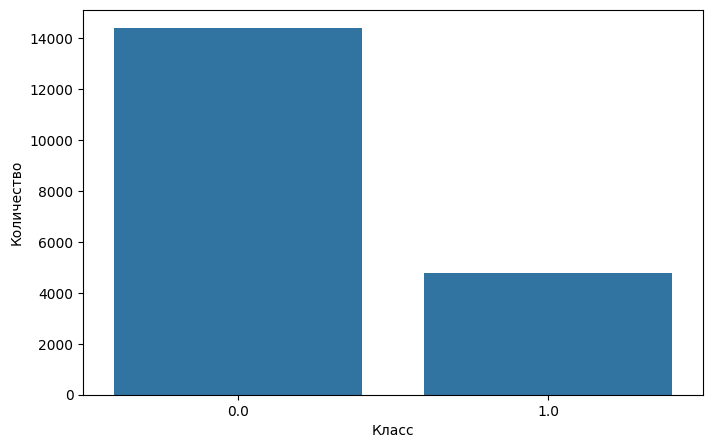

In [ ]:
# ваш код
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='target')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

Класс 0 составляет примерно 75% данных, Класс 1 — около 25%. Есть дисбаланс.

32) Создайте новую переменную **df_label**, присвойте ей трансформированный датасет df при помощи One-hot кодирования (лучше использовать pandas.get_dummies() для бинаризации)

- Примените drop_first = True
- Не забудьте удалить индексы ('enrollee_id')

In [ ]:
# ваш код
df_label = df.drop(columns=['enrollee_id'])
df_label = pd.get_dummies(df_label, drop_first=True)
df_label.head()

,city_development_index,training_hours,target,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_None,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_None,last_new_job_never
0,0.920,36,1.0,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,0.776,47,0.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
2,0.624,83,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
3,0.789,52,1.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,0.767,8,0.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
def get_metrics(y_test, y_pred, y_score, name):
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score)
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

## Modeling Baseline

33) Разбиение данных на train/test

- Разбейте данные на тренировочные и тестовые test_size=0.25
- Установите константу RAND = 10 в самом начале и используйте далее как random_state
- Не забывайте про стандартизацию
- Установите stratify=y
- Не забывайте, что нужно для записи данных в переменную X удалить целевую переменную target

In [ ]:
# ваш код
X = df_label.drop(columns=['target'])
y = df_label['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RAND, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


34) Примените стандартный метод для логистической регресии из **sklearn**

- Обучите модель на стандартизованных train и получите предсказанные значения на test
- Используйте для baseline параметр **class_weight и random_state**
- Сделайте отдельный вывод метрик в DataFrame и запишите **результат в переменную metrics**

In [ ]:
# ваш код
model = LogisticRegression(class_weight='balanced', random_state=RAND)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_score = model.predict_proba(X_test_scaled)

metrics = get_metrics(y_test, y_pred, y_score[:, 1], name='Logistic Regression')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Logistic Regression,0.761795,0.789788,0.515488,0.738693,0.607229,0.564514


35) Постройте график кривой ROC-AUC

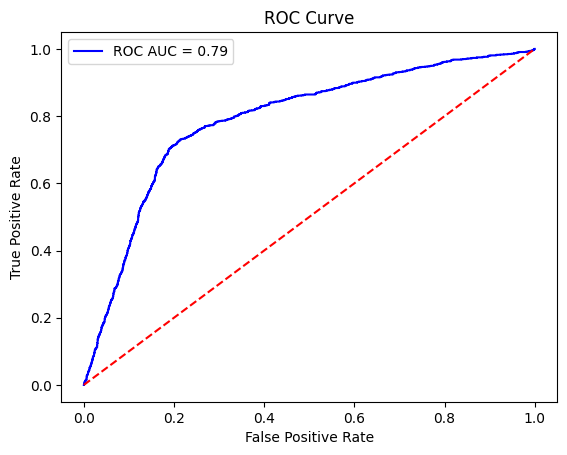

In [ ]:
# ваш код
y_probs = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.plot(fpr, tpr, color='blue', label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## GridSearch

36) Найдите параметры для LogisticRegression, используя StratifiedKFold с 3 фолдами, при помощи **GridSearch**

- Метрика для оптимизации scoring = 'roc_auc'

- Нужно использовать такие параметры как: penalty, C, solver, l1_ratio

- Не забудьте для StratifiedKFold зафиксировать random_state и class_weight

In [ ]:
# ваш код
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0.0, 0.5, 1.0]
}
model = LogisticRegression(class_weight='balanced', random_state=RAND, max_iter=1000)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=10),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1], 'l1_ratio': [0.0, 0.5, 1.0],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

37) Выведите наилучшие значения метрик и параметры после обучения GridSearchCV

In [ ]:
# ваш код
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC:", grid_search.best_score_)

Лучшие параметры: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Лучший ROC-AUC: 0.7957399688532792


38) Найдите параметры для LogisticRegression, используя StratifiedKFold с 3 фолдами, при помощи **RandomizedSearchCV**

- Метрика для оптимизации scoring = 'roc_auc'

- Нужно использовать такие параметры как: penalty, C, solver, l1_ratio

- Не забудьте для StratifiedKFold зафиксировать random_state и class_weight

In [ ]:
# ваш код
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)
param_dis = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1],
    'solver': ['liblinear', 'saga'],
    'l1_ratio': [0.1, 0.5, 1.0]
}
model = LogisticRegression(class_weight='balanced', random_state=RAND, max_iter=1000)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dis,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=10, shuffle=True),
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1000,
                                                random_state=10),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'l1_ratio': [0.1, 0.5, 1.0],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='roc_auc', verbose=1)

39) Выведите наилучшие значения метрик и параметры после обучения RandomizedSearchCV

In [ ]:
# ваш код
print("Лучшие параметры:", random_search.best_params_)
print("Лучший ROC-AUC:", random_search.best_score_)

Лучшие параметры: {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': 0.5, 'C': 0.01}
Лучший ROC-AUC: 0.7937251697533712


## Holdout

40) Обучение на фолдах на лучших параметрах

- Далее используйте кросс-валидацию со стратификацией **StratifiedKFold с 3мя фолдами** как делали ранее
- Не забудьте для StratifiedKFold зафиксировать **random_state**
- Подайте на вход модели LogisticRegression() **наилучшие параметры**, полученные путем поиска по сетке (выбрать между параметрами GridSearchCV и RandomizedSearchCV по значениям метрик - атрибут *.best_score_)
- В качестве метрики возьмите **ROC_AUC**
- Не забывайте использовать стандартизованные данные
- На каждом фолде подсчитать значение **ROC-AUC на validation** данных и **вывести**
- Выведите по итогу **среднее значение ROC-AUC** полученное на всех фолдах

In [ ]:
# ваш код
X = np.array(X)
y = np.array(y)
best_score_gs = grid_search.best_score_
best_score_rs = random_search.best_score_
if best_score_gs > best_score_rs:
    best_params = grid_search.best_params_
    print("Используем параметры из GridSearchCV:", best_params)
else:
    best_params = random_search.best_params_
    print("Используем параметры из RandomizedSearchCV:", best_params)

best_model = LogisticRegression(
    class_weight='balanced',
    random_state=RAND,
    max_iter=1000,
    **best_params
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RAND)

roc_auc_scores = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    best_model.fit(X_train, y_train)

    y_pred_proba = best_model.predict_proba(X_val)

    roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])
    roc_auc_scores.append(roc_auc)
    print(f"ROC-AUC на текущем фолде: {roc_auc:.4f}")

mean_roc_auc = np.mean(roc_auc_scores)
print(f"Среднее значение ROC-AUC на всех фолдах: {mean_roc_auc:.4f}")

Используем параметры из GridSearchCV: {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
ROC-AUC на текущем фолде: 0.7793
ROC-AUC на текущем фолде: 0.7838
ROC-AUC на текущем фолде: 0.7836
Среднее значение ROC-AUC на всех фолдах: 0.7822


41) Получите **предсказанные значения на Holdout** данных при помощи усреднения значений (для вероятностй) и моды (для меток классов), полученных при обучении на фолдах

**Сравните** результат ROC-AUC на validation (OOF) и на test данных (Holdout)


Подсказка:
- для получения средних значений на Holdout используйте np.mean(np.column_stack(****), axis=1)
- для получения моды на Holdout используйте stats.mode(np.column_stack(****), axis=1)[0]

In [ ]:
# ваш код
X_test = np.array(X_test)
y_test = np.array(y_test)

test_proba_predictions = []
test_class_predictions = []

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    best_model.fit(X_train, y_train)

    y_test_proba = best_model.predict_proba(X_test)
    test_proba_predictions.append(y_test_proba)

    y_test_class = best_model.predict(X_test)
    test_class_predictions.append(y_test_class)

mean_test_proba = np.mean(np.column_stack(test_proba_predictions), axis=1)
mode_test_class = stats.mode(np.column_stack(test_class_predictions), axis=1)[0].flatten()
roc_auc_test = roc_auc_score(y_test, mean_test_proba)

print(f"ROC-AUC на тестовых данных: {roc_auc_test:.4f}")
print(f"Среднее значение ROC-AUC на всех фолдах (OOF): {mean_roc_auc:.4f}")
print(f"Разница между ROC-AUC OOF и тестовыми данными: {mean_roc_auc - roc_auc_test:.4f}")


ROC-AUC на тестовых данных: 0.5015
Среднее значение ROC-AUC на всех фолдах (OOF): 0.7822
Разница между ROC-AUC OOF и тестовыми данными: 0.2807


In [ ]:
roc_auc_score(y_test, np.mean(np.column_stack(test_proba_predictions), axis=1))

0.5015230723510024

42) Добавьте в датасет с метриками **metrics** результаты обучения модели с **StratifiedKFold на Holdout данных**.

Где вы получили самые наилучшие результаты?

In [ ]:
metrics = pd.concat([metrics, get_metrics(y_test, mode_test_class, mean_test_proba, name='Holdout')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Logistic Regression,0.761795,0.789788,0.515488,0.738693,0.607229,0.564514
0,Holdout,0.738622,0.501523,0.483579,0.715243,0.577027,0.693147


Улучшились ли результаты на Holdout по сравнению c Baseline? **Если нет, попробуйте тщательнее подобрать значения в методах поиска по сетке и снова посмотрите результаты.**

Нет, побор значений ничего не помянел. Accuracy всегда становился только хуже